# Pass Reception and Transition

One of the key skills of a midfielder is the ability to drop back into her defensive half for receiving passes and subsequently transitioning the play to their attacking zones. The objective of this exploratory analysis is to find such ball progressing midfielders from the FA Women’s Super League (WSL) 2020-21 season and analyse them. This analysis uses event data provided by StatsBomb and 'minutes played' data provided by FBref.

Before heading into the analysis, here are some important details related to the data and some rules which we are going to use to model such ball progressing sequences:

- We are going to use a pitch configuration where the the pitch is divided into 18 zones, with 6 zones in each third of the pitch. For reference, here's an image of the same pitch configuration by [The Coaches' Voice](https://www.coachesvoice.com/):

    <img src="images/pitch_zones.jpg" alt="Football Pitch 18 Zones" width="500" height="auto">

<br>

- For a pass reception to be considered in this analysis, it must satisfy the following conditions:
    - The pass should be successfully received by a midfielder in zones 4-9.
    - The pass must have started in zones 1-9, i.e. the defensive half.

<br>

- A transition following a pass reception is considered successful if it satisfies the following conditions:
    - The transition must end in the final/attacking third, i.e. zones 13-18.
    - The transition can involve 2 players at max (the first of which is the player who receives the pass). The idea behind this is:<br>
    > A midfielder, after receiving the pass in her own defensive half, will want to move the ball into her attacking half. She can either carry the ball or pass the ball or do both to make the ball reach their attacking third - all on her own. Another option for her is to pass the ball to one of her teammates who is open and has the space and time to move the ball into the attacking third.
    >
    > In the second case, the first player saw an opportunity for progressing the ball through the second player and hence made the decision to pass the ball. Therefore, I want to give some credit to the first player because she made a decision depending on which of her teammates is open and has a higher probability of moving the ball forward. But if we add a third player, then the first player might not play a big role in the third player's decision making - the uncertainty will increase here. In other words, the first player is more certain of the second player's available choices and possible outcomes than she is for the third player.

    - The transition can have a maximum of 4 events. Here's the reason why:<br>
    > There are 2 major events in any transition - a pass and a carry. Based on numerous samples clips I watched, the most common transitions (into the attacking third) involving 2 players can be completed in 4 events - for example, player #1 carries (event count = 1) and passes (event count = 2) the ball to player #2 who then carries (event count = 3) and passes (event count = 4) the ball into the attacking third. Other examples might involve less number of events. 

<br>

- Here are the rules which are used to count events in our analysis:
    - A successful pass of any length is counted as an event and the final location of the pass is recorded (to check if the ball has reached the attacking third).
    - A successful carry is counted as an event only when the carry distance is more than 5 metres (or 5.46807 yards - since StatsBomb coordinate data is in yards). The carry end location is also recorded. 
    - If a successful carry's length is less than or equal to 5 metres then it is not counted as an event but its end location is recorded.
    - Events like dispossession, miscontrol, block, interception, clearance, unsuccessful pass, unsuccessful dribble, shot, foul will break the transition.
    - If there's a successful dribble between two successful carries, then both the carries will be combined for 'event count' and 'ball location' calculation.
    - All other events like duels and ball recoveries are ignored since those are covered by one of the above events/rules related to them.

<br>

- StatsBomb's pitch configuration is 120 yards long, i.e. the x-coordinate is from 0-120. Here are the x-coordinates for different areas of the pitch discussed above:
    - The Ball Reception Area (Zones 4-9): 20 < x < 60
    - The Pass Start Area (Defensive Half / Zones 1-9): x < 60
    - The Attacking/Final Third (Zones 13-18): x >= 80

<br>

- After preparing the data for our analysis, as a final step, we'll only keep those midfielders who have played at least 450 minutes (equivalent to 5 full matches) during the season.

<br>

Hereafter, all mentions of pass/ball receptions and successul/unsuccessful transitions will refer to the above definitions.

With the conditions and rules defined, let's dive into the code and analyse our findings!

<br>
<br>

In [1]:
# IMPORTING LIBRARIES AND PACKAGES

from statsbombpy import sb
import math
import pandas as pd
from pandasql import sqldf  # for running SQL on dataframes
import requests
from io import StringIO
import matplotlib.pyplot as plt
import numpy as np

<br>

In [2]:
# READING IN STATSBOMB EVENT DATA 

columns = [
    'id',
    'match_id',
    'index',
    'minute',
    'second',
    'possession',
    'possession_team_id',
    'possession_team',
    'type',
    'player_id',
    'player',
    'position',
    'team_id',
    'team',
    'location',
    'pass_end_location',
    'pass_outcome',
    'ball_receipt_outcome',
    'pass_recipient_id',
    'pass_recipient',
    'carry_end_location',
    'dribble_outcome',
    'foul_won_advantage',
    'related_events',
    'under_pressure'
]

events = sb.competition_events(
    country='England',
    division= "FA Women's Super League",
    season='2020/2021',
    gender='female'
)[columns]

events.head()  # dataframe containing the entire season's event data

/Users/prateek/miniconda3/envs/pass_reception_and_transition/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/prateek/miniconda3/envs/pass_reception_and_transition/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/prateek/miniconda3/envs/pass_reception_and_transition/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/prateek/miniconda3/envs/pass_reception_and_transition/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/prateek/miniconda3/envs/pass_reception_and_transition/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data acce

,id,match_id,index,minute,second,possession,possession_team_id,possession_team,type,player_id,...,pass_end_location,pass_outcome,ball_receipt_outcome,pass_recipient_id,pass_recipient,carry_end_location,dribble_outcome,foul_won_advantage,related_events,under_pressure
0,f51b1630-d1a8-4837-97b0-de862f0e299a,3775648,1,0,0,1,2647,Aston Villa,Starting XI,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1bbead8d-7790-4898-a765-3cdffeaf966e,3775648,2,0,0,1,2647,Aston Villa,Starting XI,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,caa9cf6d-dd46-4bdc-ba4c-f6fc82cb9fa9,3775609,1,0,0,1,968,Arsenal WFC,Starting XI,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f85b9236-3d19-476a-8304-57b74b6416b3,3775609,2,0,0,1,968,Arsenal WFC,Starting XI,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,b7f68694-0261-4929-ad96-907e62ec630c,3775633,1,0,0,1,2647,Aston Villa,Starting XI,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<br>

In [3]:
# READING IN STATSBOMB MATCH DATA

matches = sb.matches(competition_id=37, season_id=90)[
    [
        'match_id', 'competition', 'season', 
        'match_date', 'home_team', 'home_score', 
        'away_score', 'away_team'
    ]
]

matches

/Users/prateek/miniconda3/envs/pass_reception_and_transition/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


,match_id,competition,season,match_date,home_team,home_score,away_score,away_team
0,3775648,England - FA Women's Super League,2020/2021,2021-02-28,Aston Villa,0,4,Arsenal WFC
1,3775609,England - FA Women's Super League,2020/2021,2021-04-28,Arsenal WFC,2,0,West Ham United LFC
2,3775633,England - FA Women's Super League,2020/2021,2021-02-06,Aston Villa,1,0,Tottenham Hotspur Women
3,3775570,England - FA Women's Super League,2020/2021,2021-03-28,Brighton & Hove Albion WFC,0,5,Everton LFC
4,3775581,England - FA Women's Super League,2020/2021,2021-03-28,Chelsea FCW,2,0,Aston Villa
...,...,...,...,...,...,...,...,...
126,3775608,England - FA Women's Super League,2020/2021,2021-01-17,West Ham United LFC,0,1,Tottenham Hotspur Women
127,3775599,England - FA Women's Super League,2020/2021,2021-04-20,West Ham United LFC,0,0,Aston Villa
128,3775554,England - FA Women's Super League,2020/2021,2020-11-14,Everton LFC,1,1,Reading WFC
129,3775652,England - FA Women's Super League,2020/2021,2021-02-07,Chelsea FCW,1,2,Brighton & Hove Albion WFC


<br>

In [4]:
# function to find if a pass started in defensive half for a given ball reception event
def pass_start_location(x):
    return events[
        events.id == list(filter(lambda x: events[events.id == x].type.item() == 'Pass', x))[0]
    ].location.item()[0] < 60

<br>

In [5]:
ball_receipts = events[
    (events.type == 'Ball Receipt*') \
    & (events.ball_receipt_outcome.isna()) \
    & (events.position.str.contains('Midfield'))
] # selecting event data for successful ball receptions by midfielders

ball_receipts = ball_receipts[
    ball_receipts.location.apply(lambda x: 20 < x[0] < 60)
] # checking if ball reception happened in zones 4-9

ball_receipts = ball_receipts[
    ball_receipts.related_events.apply(pass_start_location)
] # checking if the associated pass started in the defensive half


ball_receipts = pd.merge(
    left = ball_receipts, 
    right = matches, 
    how = 'left', 
    on = 'match_id'
) # joining ball reception and match data (to have match details for video verification)

'''
dataframe containing pass/ball reception event data (based on our definition 
of ball reception events discussed in the beginning of the analysis)
'''
ball_receipts.head() 

,id,match_id,index,minute,second,possession,possession_team_id,possession_team,type,player_id,...,foul_won_advantage,related_events,under_pressure,competition,season,match_date,home_team,home_score,away_score,away_team
0,0e9e4a0c-46ea-4aea-9c62-b4883bf1d993,3775648,9,0,1,2,968,Arsenal WFC,Ball Receipt*,10405.0,...,NaN,[4467e274-205f-41be-ab7e-62ece2697dbc],NaN,England - FA Women's Super League,2020/2021,2021-02-28,Aston Villa,0,4,Arsenal WFC
1,eab2985b-c33f-40fd-9a8a-02bc356a0a8e,3775648,15,0,6,2,968,Arsenal WFC,Ball Receipt*,10405.0,...,NaN,[51af8ad7-5652-4717-9547-796fd8212fcf],NaN,England - FA Women's Super League,2020/2021,2021-02-28,Aston Villa,0,4,Arsenal WFC
2,fe6cf834-bb08-4497-85dc-29f66ac5a744,3775648,46,0,31,3,2647,Aston Villa,Ball Receipt*,46539.0,...,NaN,[5cd79af7-7929-4b2b-a3a7-9d9f839db461],NaN,England - FA Women's Super League,2020/2021,2021-02-28,Aston Villa,0,4,Arsenal WFC
3,be59c93a-1476-4512-b90f-b02435b31ba0,3775648,57,0,40,4,968,Arsenal WFC,Ball Receipt*,10650.0,...,NaN,[6ebcfd9e-39ed-490b-a120-c8a92c1a1c44],NaN,England - FA Women's Super League,2020/2021,2021-02-28,Aston Villa,0,4,Arsenal WFC
4,94ab09b3-ae11-4630-8a70-35c5116348d0,3775648,61,0,44,4,968,Arsenal WFC,Ball Receipt*,10658.0,...,NaN,[9674c1be-0675-499b-9328-82ec1f5fcc39],NaN,England - FA Women's Super League,2020/2021,2021-02-28,Aston Villa,0,4,Arsenal WFC


<br>

In [6]:
data = dict()

'''
For every ball reception event (outer for loop), we'll now check if the 
subsequent events (inner for loop) in the same possession lead to a 
successful transition or not (based on the definition of transitions 
discussed in the beginning of this analysis).

For learning more about sequences and possessions, you can read this
article: 
https://www.statsperform.com/resource/introducing-a-possessions-framework/
'''
# outer for loop
for receipt in ball_receipts.itertuples():
    event_dict = dict()
    event_count = 0 # to count number of events
    final_location_x = receipt.location[0] # to track the ball's latest location
    players = set() # to keep a record of unique players involved
    dribble = False
    last_carry_start_location = receipt.location
    last_carry_distance = 0

    # dataframe with events following the ball reception in the same possession
    possession_events = events[
        (events.match_id == receipt.match_id) \
        & (events.possession == receipt.possession) \
        & (events['index'] > receipt.index)
    ].sort_values('index') 

    # inner for loop
    for event in possession_events.itertuples():

        # break if attacking third is reached or event/player limit is reached
        if final_location_x >= 80 or event_count == 4 or len(players) == 2:
            break
        
        else:
            # for a successful pass
            if event.type == 'Pass' and pd.isna(event.pass_outcome):
                event_count += 1
                final_location_x = event.pass_end_location[0]
                players.add(event.player_id)

            # for a carry which doesn't follow a successful dribble: 
            elif dribble == False and event.type == 'Carry':
                if math.dist(event.location, event.carry_end_location) > 5.46807:
                    event_count += 1
                final_location_x = event.carry_end_location[0]
                players.add(event.player_id)

                # the following 2 variables will help combine 2 carries sandwiching a successful dribble
                last_carry_start_location = event.location
                last_carry_distance = math.dist(event.location, event.carry_end_location)

            # for defensive actions, stoppages in play or shots which break the transition
            elif event.type in ['Dispossessed', 'Miscontrol', 'Interception', 'Clearance', 'Block', 'Shot'] \
            or (event.type == 'Pass' and pd.notna(event.pass_outcome)) \
            or (event.type == 'Dribble' and event.dribble_outcome == 'Incomplete') \
            or (event.type == 'Foul Won' and pd.isna(event.foul_won_advantage)):
                break

            # for a successful dribble
            elif event.type == 'Dribble' and event.dribble_outcome == 'Complete':
                dribble = True

            # for a carry following a successful dribble:
            elif dribble == True and event.type == 'Carry':

                # both the carries are combined and considered to be a single carry
                final_location_x = event.carry_end_location[0]
                dribble = False
                last_carry_distance = math.dist(last_carry_start_location, event.carry_end_location)

                # if the carry before the dribble was less than or equal to 5 metres long
                # and if both the carries combined are more than 5 metres long, then the
                # event_count variable is increased by 1
                if last_carry_distance <= 5.46807 \
                and math.dist(last_carry_start_location, event.carry_end_location) > 5.46807:
                    event_count += 1

            # for all other events
            else:
                continue
            
    event_dict['successful_transition'] = True if final_location_x >= 80 else False
    event_dict['transition_final_location_x'] = final_location_x
    event_dict['transition_event_count'] = event_count 
    event_dict['transition_players_involved'] = len(players)
    data[receipt.id] = event_dict

<br>

In [7]:
ball_receipts = pd.merge(
    left=ball_receipts,
    right=pd.DataFrame.from_dict(
        data=data, 
        orient='index'
    ).reset_index().rename(columns={'index': 'id'}),
    how='left',
    on='id'
) # joining ball_receipts dataframe with corresponding transition data

ball_receipts.head()

,id,match_id,index,minute,second,possession,possession_team_id,possession_team,type,player_id,...,season,match_date,home_team,home_score,away_score,away_team,successful_transition,transition_final_location_x,transition_event_count,transition_players_involved
0,0e9e4a0c-46ea-4aea-9c62-b4883bf1d993,3775648,9,0,1,2,968,Arsenal WFC,Ball Receipt*,10405.0,...,2020/2021,2021-02-28,Aston Villa,0,4,Arsenal WFC,False,40.3,1,2
1,eab2985b-c33f-40fd-9a8a-02bc356a0a8e,3775648,15,0,6,2,968,Arsenal WFC,Ball Receipt*,10405.0,...,2020/2021,2021-02-28,Aston Villa,0,4,Arsenal WFC,False,63.4,2,2
2,fe6cf834-bb08-4497-85dc-29f66ac5a744,3775648,46,0,31,3,2647,Aston Villa,Ball Receipt*,46539.0,...,2020/2021,2021-02-28,Aston Villa,0,4,Arsenal WFC,False,72.1,2,2
3,be59c93a-1476-4512-b90f-b02435b31ba0,3775648,57,0,40,4,968,Arsenal WFC,Ball Receipt*,10650.0,...,2020/2021,2021-02-28,Aston Villa,0,4,Arsenal WFC,False,43.9,2,2
4,94ab09b3-ae11-4630-8a70-35c5116348d0,3775648,61,0,44,4,968,Arsenal WFC,Ball Receipt*,10658.0,...,2020/2021,2021-02-28,Aston Villa,0,4,Arsenal WFC,True,80.6,2,2


<br>

In [8]:
# READING IN 'MINUTES PLAYED' DATA PROVIDED BY FBREF 

# This data will help us calculate 'per 90' metrics

source = requests.get('https://fbref.com/en/comps/189/2020-2021/playingtime/2020-2021-Womens-Super-League-Stats')

minutes_played = pd.read_html(
    io=StringIO(source.text.replace('<!--','').replace('-->',''))
)[2].droplevel(level=0, axis=1)[['Player', 'Pos', 'Min']]

minutes_played.head()

,Player,Pos,Min
0,Angela Addison,FW,1270
1,Asmita Ale,DF,1457
2,Flo Allen,DF,1086
3,Jonna Andersson,DF,1563
4,Mackenzie Arnold,GK,1440


<br>

In [9]:
# grouping by player since there can be multiple rows for the same player changing clubs mid-season
# using SQL since aggregations are easier to write in SQL
minutes_played = sqldf(
    '''
    SELECT 
        player,
        SUM(CAST(COALESCE(min, 0) AS INT)) AS minutes_played
    FROM minutes_played
    GROUP BY 1
    '''
)

minutes_played.head()

,Player,minutes_played
0,Abbey-Leigh Stringer,695
1,Abbi Grant,38
2,Abbie Cowie,0
3,Abbie McManus,1305
4,Abby Dahlkemper,645


<br>

In [10]:
cte = ball_receipts[
    [
        'id', 'player_id', 'player', 'position', 
        'team_id', 'team', 'under_pressure', 
        'successful_transition', 'transition_players_involved'
    ]
]

# creating dataframe with player summary data for receptions and transitions
results = sqldf(
    '''
    SELECT 
        CAST(player_id AS INT) AS player_id,
        player,
        COUNT(id) AS receptions,
        COUNT(CASE WHEN successful_transition = TRUE THEN id END) AS transitions,
        COUNT(
            CASE WHEN successful_transition = TRUE AND transition_players_involved = 1 THEN id END
        ) AS solo_transitions
    FROM cte
    GROUP BY 1, 2
    '''
)

results.head()

,player_id,player,receptions,transitions,solo_transitions
0,4638,Drew Spence,41,5,2
1,4641,Francesca Kirby,13,1,1
2,4643,Georgia Stanway,73,2,2
3,4645,Isobel Mary Christiansen,392,23,12
4,4646,Claire Emslie,15,4,3


<br>

In [11]:
# adding 'minutes played' data to results dataframe
results = sqldf(
    '''
    SELECT 
        r.*,
        mp.minutes_played
    FROM 
        results r
        LEFT JOIN
        minutes_played mp
        ON r.player = mp.player
    '''
)

results.head()

,player_id,player,receptions,transitions,solo_transitions,minutes_played
0,4638,Drew Spence,41,5,2,249.0
1,4641,Francesca Kirby,13,1,1,NaN
2,4643,Georgia Stanway,73,2,2,1489.0
3,4645,Isobel Mary Christiansen,392,23,12,NaN
4,4646,Claire Emslie,15,4,3,1289.0


<br>
<br>

As evident, some players have null minutes_played value. This is because these players' names are different in StatsBomb and FBref. For instance, Franscesca Kirby (in StatsBomb) goes by her short name Fran Kirby in FBref, and Isobel Mary Christiansen (in StatsBomb) goes by her short name Izzy Christiansen in FBref. Due to this, the join didn't return any result for these players. To tackle this issue, I manually matched names in the StatsBomb and FBref data and filled in the missing values in a spreadsheet. Now, I'll read in that data and update the results dataframe.

<br>

In [12]:
missing_minutes_played = pd.read_csv('data/missing_minutes_played.csv')
missing_minutes_played.head()

,player_id,player,minutes_played
0,4641,Francesca Kirby,1378
1,4645,Isobel Mary Christiansen,1917
2,4647,So-Yun Ji,1307
3,4657,Anita Amma Ankyewah Asante,1659
4,4846,Lucia Leon,245


<br>

In [13]:
results = sqldf(
    '''
    SELECT 
        r.player_id,
        r.player,
        r.receptions,
        r.transitions,
        r.solo_transitions,
        CAST(COALESCE(r.minutes_played, mmp.minutes_played) AS INT) AS minutes_played
    FROM 
        results r
        LEFT JOIN 
        missing_minutes_played mmp
        ON r.player_id = mmp.player_id
    '''
)

results.head()

,player_id,player,receptions,transitions,solo_transitions,minutes_played
0,4638,Drew Spence,41,5,2,249
1,4641,Francesca Kirby,13,1,1,1378
2,4643,Georgia Stanway,73,2,2,1489
3,4645,Isobel Mary Christiansen,392,23,12,1917
4,4646,Claire Emslie,15,4,3,1289


<br>
<br>

There's still one problem present in this data. Look at Sam Kerr's numbers below. She had registered only 2 receptions as a midfielder during the entire season, but she has played 1,517 minutes (equivalent to almost 16 full matches).

<br>

In [14]:
results[results.player.str.contains('Kerr')]

,player_id,player,receptions,transitions,solo_transitions,minutes_played
14,4961,Samantha May Kerr,2,0,0,1517


<br>
<br>

We can't calculate 'per 90' metrics with these numbers because most of her playing time actually came from non-midfield positions. Look at her positional data below. She had played only 1 match as a midfielder and the rest of her matches as a forward or a winger (while also changing positions mid-match since the sum of number_of_matches is more than 22, which is the maximum number of matches a player could have played that season).

<br>

In [15]:
positional_data = events[['player_id', 'player', 'position', 'match_id']]

sqldf(
    '''
    SELECT 
        position,
        COUNT(DISTINCT match_id) AS number_of_matches
    FROM positional_data
    WHERE LOWER(player) LIKE '%kerr%'
    GROUP BY 1
    ORDER BY 2 DESC
    '''
)

,position,number_of_matches
0,Center Forward,11
1,Left Wing,5
2,Right Wing,3
3,Left Center Forward,3
4,Right Center Forward,1
5,Center Defensive Midfield,1


<br>
<br>

To solve this problem, we have to keep only those players in the results dataframe whose most-played position in the 2020-21 season was in the midfield:

<br>

In [16]:
results = sqldf(
    '''
    -- Number of matches played by position for each player:
    WITH cte AS (
        SELECT 
            CAST(player_id AS INT) AS player_id,
            player,
            position,
            COUNT(DISTINCT match_id) AS number_of_matches
        FROM positional_data
        WHERE player_id IS NOT NULL
        GROUP BY 1, 2, 3
    ),

    -- Ranking positions for each player based on number of matches played by the player in that position:
    position_ranks AS (
        SELECT 
            *,
            DENSE_RANK() OVER (PARTITION BY player_id, player ORDER BY number_of_matches DESC) 
                AS position_rank
        FROM cte
    ),

    -- Most played position for each player:
    most_played_positions AS (
        SELECT *
        FROM position_ranks
        WHERE position_rank = 1
    )

    -- Keeping only those players in the results dataframe whose most played position was in midfield:
    SELECT DISTINCT r.*
    FROM 
        results r
        LEFT JOIN
        most_played_positions mpp
        ON r.player_id = mpp.player_id
    WHERE LOWER(mpp.position) LIKE '%midfield%'
    '''
)

results.head()

,player_id,player,receptions,transitions,solo_transitions,minutes_played
0,4638,Drew Spence,41,5,2,249
1,4645,Isobel Mary Christiansen,392,23,12,1917
2,4647,So-Yun Ji,302,33,22,1307
3,4658,Keira Walsh,436,22,10,1776
4,4841,Destiney Toussaint,4,0,0,74


<br>
<br>

As a final step, we'll only keep those midfielders in the results dataframe who have played at least 450 minutes (equivalent to 5 full matches) during the season:

<br>

In [17]:
results = results[results.minutes_played >= 450]

results.head()

,player_id,player,receptions,transitions,solo_transitions,minutes_played
1,4645,Isobel Mary Christiansen,392,23,12,1917
2,4647,So-Yun Ji,302,33,22,1307
3,4658,Keira Walsh,436,22,10,1776
6,4865,Josie Green,128,4,1,1003
7,5016,Jessica Fishlock,241,20,14,1601


<br>
<br>

Now, we'll calculate 'per 90' metrics for all the players in the results dataframe:

<br>

In [18]:
results['receptions_per_90'] = round(
    (results.receptions * 1.0 / results.minutes_played) * 90, 1
    )

results['transitions_per_90'] = round(
    (results.transitions * 1.0 / results.minutes_played) * 90, 1
    )

results['solo_transitions_per_90'] = round(
    (results.solo_transitions * 1.0 / results.minutes_played) * 90, 1
    )

results.head()

,player_id,player,receptions,transitions,solo_transitions,minutes_played,receptions_per_90,transitions_per_90,solo_transitions_per_90
1,4645,Isobel Mary Christiansen,392,23,12,1917,18.4,1.1,0.6
2,4647,So-Yun Ji,302,33,22,1307,20.8,2.3,1.5
3,4658,Keira Walsh,436,22,10,1776,22.1,1.1,0.5
6,4865,Josie Green,128,4,1,1003,11.5,0.4,0.1
7,5016,Jessica Fishlock,241,20,14,1601,13.5,1.1,0.8


<br>
<br>

The complete 'pass reception and transition' data for these midfielders is also saved in a CSV file in the 'data' folder of this repository:

<br>

In [19]:
results.to_csv('data/pass_reception_and_transition.csv')

<br>
<br>

Finally, let's analyse these players:

<br>

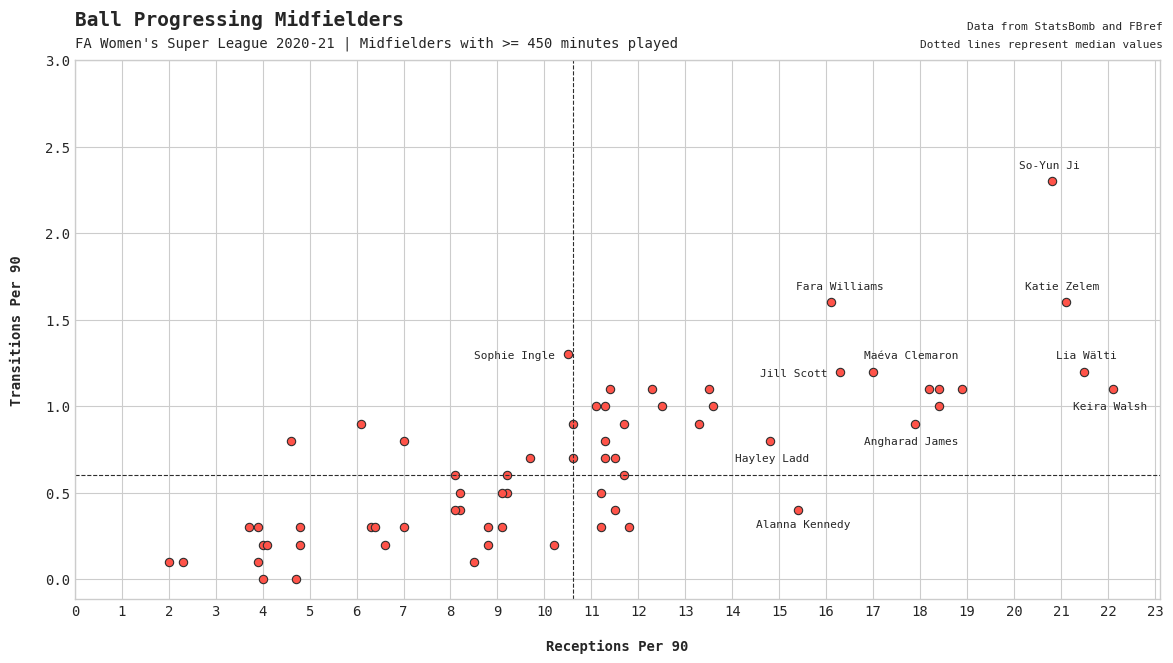

In [20]:
plt.figure(figsize=(14, 7))
plt.style.use('seaborn-v0_8-whitegrid')

plt.scatter(
    x=results.receptions_per_90, 
    y=results.transitions_per_90, 
    c='#FF5349', 
    edgecolor='#2E2E2E', 
    linewidth=0.8
)

plt.title(
    label='Ball Progressing Midfielders', 
    fontweight='bold', 
    family='monospace', 
    fontsize=14, 
    loc='left', 
    pad=25
)
plt.text(
    x=0, 
    y=3.075, 
    s="FA Women's Super League 2020-21 | Midfielders with >= 450 minutes played", 
    family='monospace', 
    fontsize=10
)
plt.text(
    x=19, 
    y=3.175, 
    s="Data from StatsBomb and FBref", 
    family='monospace', 
    fontsize=8
)
plt.text(
    x=18, 
    y=3.075, 
    s="Dotted lines represent median values", 
    family='monospace', 
    fontsize=8
)
plt.xticks(np.arange(0, 23 + 1, 1), family='monospace', fontsize=10)
plt.yticks(np.arange(0, 3.5, 0.5), family='monospace', fontsize=10)
plt.xlabel(
    'Receptions Per 90', 
    labelpad=15, 
    fontsize=10, 
    family='monospace', 
    fontweight='bold'
)
plt.ylabel(
    'Transitions Per 90', 
    labelpad=15, 
    fontsize=10, 
    family='monospace', 
    fontweight='bold'
)
plt.axhline(
    y=np.percentile(a=results.transitions_per_90, q=50), 
    color='#2E2E2E', 
    linestyle='--', 
    linewidth=0.8
)
plt.axvline(
    x=np.percentile(a=results.receptions_per_90, q=50), 
    color='#2E2E2E', 
    linestyle='--', 
    linewidth=0.8
)
plt.text(x=20.1, y=2.375, s="So-Yun Ji", family='monospace', fontsize=8)
plt.text(x=15.35, y=1.675, s="Fara Williams", family='monospace', fontsize=8)
plt.text(x=20.225, y=1.675, s="Katie Zelem", family='monospace', fontsize=8)
plt.text(x=20.9, y=1.275, s="Lia Wälti", family='monospace', fontsize=8)
plt.text(x=21.25, y=0.98, s="Keira Walsh", family='monospace', fontsize=8)
plt.text(x=8.5, y=1.275, s="Sophie Ingle", family='monospace', fontsize=8)
plt.text(x=14.6, y=1.175, s="Jill Scott", family='monospace', fontsize=8)
plt.text(x=16.8, y=1.275, s="Maéva Clemaron", family='monospace', fontsize=8)
plt.text(x=14.5, y=0.3, s="Alanna Kennedy", family='monospace', fontsize=8)
plt.text(x=14.05, y=0.68, s="Hayley Ladd", family='monospace', fontsize=8)
plt.text(x=16.8, y=0.78, s="Angharad James", family='monospace', fontsize=8)
plt.show()

<br>
<br>

Three players stand out here: So-Yun Ji, Fara Williams, and Katie Zelem. 

<br>

Ji played an instrumental role for Chelsea in their title-winning season where they won the FA WSL, FA Cup, League Cup, and FA Community Shield. They even finished second in Champions League. 

In the [words](https://archive.ph/20210510141630/https://www.theguardian.com/football/2021/may/10/player-ratings-for-chelseas-wsl-title-winners#selection-1179.0-1179.224) of Suzanne Wrack of The Guardian after Chelsea's WSL title win:

> Arguably the best foreign player in WSL history Ji continues to be one of Chelsea’s most creative players. The South Korean twists her way out of the tightest gaps and has an eye for passes that few others would dare to try.

The 7 times Korean FA Women's Player of the Year recorded a staggering 33 successful transitions (2.3 per 90), out of which 22 (1.5 per 90) were solo transitions (which we will discuss next), in the 2020-21 WSL season.

<br>

England's highest capped footballer (male or female) and one of the first inductees of the FA WSL Hall of Fame, Fara Williams hung up her boots at the end of the 2020-21 season with Reading. Even in her last season before retiring from football, she outshone other midfielders by recording 1.6 successful transitions per 90 which puts her above 95% of the midfielders analysed.

<br>

Manchester United captain Katie Zelem followed the footsteps of her role model Fara Williams and recorded 22 transitions (1.6 per 90) in the 2020-21 WSL season, out of which an impressive 17 were solo transitions (1.2 per 90) which puts her right behind Ji.

<br>

<br>

Let's now have a look at the solo transitions data. Solo transitions are those sequences where the midfielder receiving the pass solely transition the ball to the attacking third through a pass or a carry or a carry followed by a pass. 

<br>

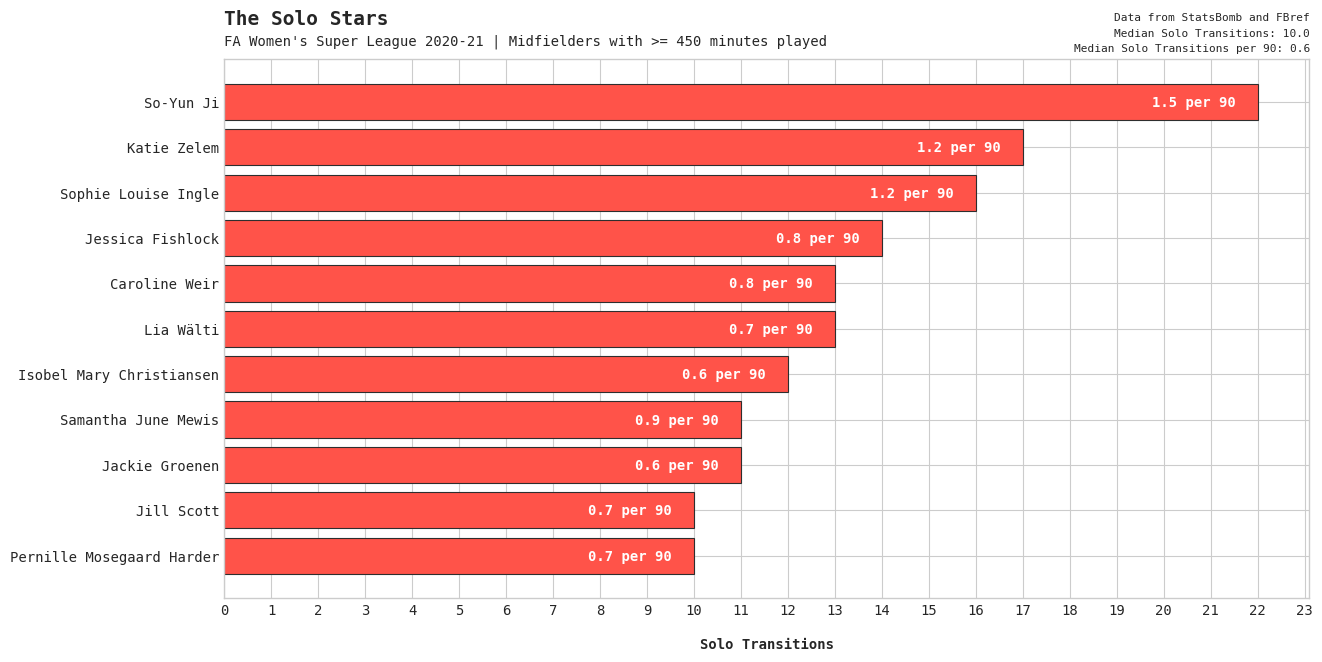

In [21]:
solo_stars = sqldf(
    '''
    SELECT 
        player_id,
        player,
        solo_transitions,
        solo_transitions_per_90
    FROM results
    ORDER BY 3 DESC, 4 DESC, 1
    LIMIT 11
    '''
).sort_values(['solo_transitions', 'solo_transitions_per_90'])

plt.figure(figsize=(14, 7))
plt.style.use('seaborn-v0_8-whitegrid')

plt.barh(
    solo_stars.player, 
    solo_stars.solo_transitions, 
    color='#FF5349', 
    edgecolor='#2E2E2E', 
    linewidth=0.8
)
plt.title(
    label='The Solo Stars', 
    fontweight='bold', 
    family='monospace', 
    fontsize=14, 
    loc='left', 
    pad=25
)
plt.text(
    x=0, 
    y=11.25, 
    s="FA Women's Super League 2020-21 | Midfielders with >= 450 minutes played", 
    family='monospace', 
    fontsize=10
)
plt.text(
    x=18.95, 
    y=11.8, 
    s="Data from StatsBomb and FBref", 
    family='monospace', 
    fontsize=8
)
plt.text(
    x=18.95, 
    y=11.45, 
    s=f"Median Solo Transitions: {np.percentile(solo_stars.solo_transitions, 0.5)}", 
    family='monospace', 
    fontsize=8
)
plt.text(
    x=18.1, 
    y=11.1, 
    s=f"Median Solo Transitions per 90: {np.percentile(solo_stars.solo_transitions_per_90, 0.5)}", 
    family='monospace', 
    fontsize=8
)
plt.xticks(np.arange(0, 23 + 1, 1), family='monospace', fontsize=10)
plt.yticks( family='monospace', fontsize=10)
plt.xlabel(
    'Solo Transitions', 
    labelpad=15, 
    fontsize=10, 
    family='monospace', 
    fontweight='bold'
)
plt.text(x=19.75, y=9.9, s="1.5 per 90", family='monospace', fontsize=10, color='white', fontweight='bold')
plt.text(x=14.75, y=8.9, s="1.2 per 90", family='monospace', fontsize=10, color='white', fontweight='bold')
plt.text(x=13.75, y=7.9, s="1.2 per 90", family='monospace', fontsize=10, color='white', fontweight='bold')
plt.text(x=11.75, y=6.9, s="0.8 per 90", family='monospace', fontsize=10, color='white', fontweight='bold')
plt.text(x=10.75, y=5.9, s="0.8 per 90", family='monospace', fontsize=10, color='white', fontweight='bold')
plt.text(x=10.75, y=4.9, s="0.7 per 90", family='monospace', fontsize=10, color='white', fontweight='bold')
plt.text(x=9.75, y=3.9, s="0.6 per 90", family='monospace', fontsize=10, color='white', fontweight='bold')
plt.text(x=8.75, y=2.9, s="0.9 per 90", family='monospace', fontsize=10, color='white', fontweight='bold')
plt.text(x=8.75, y=1.9, s="0.6 per 90", family='monospace', fontsize=10, color='white', fontweight='bold')
plt.text(x=7.75, y=0.9, s="0.7 per 90", family='monospace', fontsize=10, color='white', fontweight='bold')
plt.text(x=7.75, y=-0.1, s="0.7 per 90", family='monospace', fontsize=10, color='white', fontweight='bold')
plt.show()

<br>
<br>

As mentioned earlier, So-Yun Ji made an astounding 22 solo transitions (1.5 per 90) in the 2020-21 WSL season. She was followed by Katie Zelem who made 17 solo transitions (1.2 per 90). Ji's Chelsea teammate Sophie Ingle is third on the list with 16 solo transitions (1.2 per 90). Players who can make individual contributions like this can have a huge impact on a team's chances of scoring more goals and winning games.

Enough with data and numbers! Let's have a look at some match clips of So-Yun Ji to understand how impactful these transitions are:

1. Look at [this](https://youtu.be/K6AZekdTNcI?si=c9NllsWTUBMWNvKB&t=3247) possession clip. At 45:04, you can see Ji communicating with her right back Maren Mjelde - possibly Ji asking her to move up on the wing to receive a pass from her. Starting at 45:08, you can see Ji dropping a bit to receive the ball while simultaneously checking her shoulder multiple times for incoming pressure and possible carry/pass options (an essential skill of all top-class players). At 45:13, Ji passes the ball to Maren, who quickly runs into zone 14 (highly valuable zone) completing the transition.
2. In [this](https://youtu.be/VZwPClTUEag?si=NHSqCvE2wg2xDbwc&t=4167) possession clip, look at Ji confidently asking for the ball at 54:59 while simultaneously checking her shoulders for incoming opponents. She then carries the ball and makes a pass into the attacking third (left wing).
3. [This](https://youtu.be/VZwPClTUEag?si=IIGQ7KwPfkZGQ_5I&t=4262) has to be my favourite possession clip involving Ji. This has to be the one-clip summary of this analysis. If someone doesn't want to read the entire analysis, I'll just ask them to watch this clip. So, Ji chests down a throw pass from her goalkeeper (while being under pressure from three opponents), turns around, and makes a volleyed line-breaking pass to Fran Kirby. Fran then makes a one-touch low cross to Sam Kerr who converts it into a goal. All in all, Ji got a pre-assist, Fran got an assist, and Sam scored an important goal for the team - all of this in 7 seconds. The best part is Ji already knew what she would do once she gets the pass. An absolute genius!

<br>

<br>

I hope these clips were able to drive home the point of this entire analysis. A midfielder who can drop into her defensive half to receive a pass and transition the ball into her attacking third can increase the chances of her team to score more goals and win games.

This analysis can act as an base for multiple applications:
- player recruitment
- opponent analysis
- finding out which two players combine the most in a team to create attacking opportunities
- if combined with tracking data, we might be able to quantify the effort put by these midfielders to drop back and receive the balls through distance moved or amount of reduction in pressure from where they started to drop back to where they receive the ball (since these players will try to move into spaces to make it easy for the passer to make the pass and for them to receive it)
- performing the same analysis for a different pitch configuration, like the '5 lane - 2 half spaces' configuration.

I'm also looking forward to your feedback as well, if any, on how to make this better. Please let me know your thoughts/suggestions/advice on [Twitter](https://twitter.com/PrateekSenapati), [LinkedIn](https://www.linkedin.com/in/prateek-senapati/), or through email at <prateek1210s@gmail.com>.

<br>